In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
import timeit

# Pre-processing
from sklearn.preprocessing import StandardScaler

# Models from Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics

## Load Dataset

In [3]:
attributes_data = 'dress_data/Attribute_DataSet.xlsx'
sales_data = 'dress_data/Dress_Sales.xlsx'

att = pd.read_excel(attributes_data)
sales = pd.read_excel(sales_data)

## Data Cleaning

In [4]:
def clean_data(df):
    # Clean up Price column
    df = df.replace({'Price':{'Average':'medium',
                                'Low':'low',
                                'High':'high',
                                'very-high':'vhigh',
                                'Medium':'medium'}})
    
    # Clean up Size column
    df = df.replace({'Size':{'small':'S',
                             's':'S',
                             'free':'F'}})
    
    # Clean up Style Column
    df["Style"] = df["Style"].str.lower()
    df = df.replace({'Style':{'flare':'other',
                              'fashion':'other',
                              'ol':'other'}})
    
    # Clean up Season column
    df = df.replace({'Season':{'Automn':'autumn',
                               'automn':'autumn'}})
    df["Season"] = df["Season"].str.lower()
    
    # Clean up Neckline column
    df["NeckLine"] = df["NeckLine"].str.lower()
    df = df.replace({'Neckline':{'open':'other',
                                   'scoop':'other',
                                   'halter':'other',
                                   'backless':'other',
                                   'halter':'other',
                                   'ruffled':'other',}})
    
    # Clean up SleeveLength column
    df = df.replace({'SleeveLength':{'sleevless':'sleeveless',
                                   'sleeevless':'sleeveless',
                                   'sleveless':'sleeveless',
                                   'thressqatar':'threequarter',
                                   'threequater':'threequarter',
                                   'capsleeves':'cap-sleeves',
                                   'half':'halfsleeve',
                                   'urndowncollor':'sleeveless',
                                   'turndowncollor':'sleeveless'}})

    df["SleeveLength"] = df["SleeveLength"].str.lower()
    
    # Clean up Material column
    df = df.replace({'Material':{'chiffonfabric':'chiffon',
                                 'shiffon':'chiffon',
                                 'sill':'silk'}})
    
    for each in ['microfiber','lycra', 'linen', 'acrylic', 'viscos', 
                 'sill', 'knitting', 'modal', 'wool', 'model', 'lace']:
        df = df.replace({'Material':{each:'other'}})

    df["Material"] = df["Material"].str.lower()
    
    # Clean up Fabric Type column
    df = df.replace({'FabricType':{'shiffon':'chiffon'}})

    df['FabricType'] = df['FabricType'].where(lambda x: x.isin(('chiffon', 
                                                                'broadcloth', 
                                                                'worsted',
                                                                'jersey',
                                                                'sattin',
                                                                 np.nan)),'other')
    
    # Clean up Decoration column
    df['Decoration']=df['Decoration'].where(lambda x: x.isin(('lace', 
                                                              'sashes', 
                                                              'beading',
                                                              'hollowout',
                                                              'applique',
                                                              'ruffles',
                                                              'bow',
                                                              'sequined',
                                                              'button',
                                                              'pockets',
                                                              'embroidary',
                                                               np.nan)),'other')
    
    # Clean up Pattern Column
    df = df.replace({'Pattern Type':{'leapord':'animal',
                                   'leopard':'animal'}})
                                   
    df['Pattern Type'] = df['Pattern Type'].where(lambda x: x.isin(('solid', 
                                                                    'print', 
                                                                    'patchwork',
                                                                    'animal',
                                                                    'striped',
                                                                    'dot',
                                                                    'geometric ',
                                                                    np.nan)),'other')
    
    return df

In [5]:
df1 = clean_data(att)

In [6]:
df1.drop(columns=['FabricType','Decoration'], inplace=True)

In [7]:
df1['Size'].unique()

array(['M', 'L', 'XL', 'F', 'S'], dtype=object)

In [8]:
df1 = df1.replace({'Price':{'low':1,
                          'medium':2,
                          'high':3,
                          'vhigh':4}})


df1 = df1.replace({'Size':{'S':1,
                           'M':2,
                           'L':3,
                           'XL':4,
                           'F':5}})                          

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Dress_ID        500 non-null    int64  
 1   Style           500 non-null    object 
 2   Price           498 non-null    float64
 3   Rating          500 non-null    float64
 4   Size            500 non-null    int64  
 5   Season          498 non-null    object 
 6   NeckLine        497 non-null    object 
 7   SleeveLength    498 non-null    object 
 8   waiseline       413 non-null    object 
 9   Material        372 non-null    object 
 10  Pattern Type    391 non-null    object 
 11  Recommendation  500 non-null    int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 47.0+ KB


In [102]:
df1.Season.unique()

array(['summer', 'autumn', 'spring', 'winter', nan], dtype=object)

## Preprocessing

In [10]:

def convert_to_categories(df):
    
    for column, contents in df.items():
        if pd.api.types.is_string_dtype(contents):
            df[column] = contents.astype("category").cat.as_ordered()    
    return df

def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res) 

def fill_missing(df):
    # Fill missing categorical data, and note missing instances
    for feature, value in df.items():
        
        if not pd.api.types.is_numeric_dtype(value):
            df[feature+"_was_missing"] = pd.isnull(value)
           
            # Add +1 to the category code since pandas encodes missing values as -1
            df[feature] = pd.Categorical(value).codes+1      
    return df

def join_datasets(df1, df2):
    # df1 represents attributes dataset
    # df2 represents sales dataset

    df2['total'] = df2.loc[:, df2.columns != 'Dress_ID'].sum(axis=1)
    df2 = df2[['Dress_ID','total']].reset_index()
    df1 = df1.reset_index()
    
    merged_df = df1.merge(df2, left_index=True, right_index=True)
    return merged_df
    

def split_dataset(df):
    
    # Seperate features from target variable. Note we dropped Dress_ID because it is a unique identifier
    X = df.drop(["Recommendation","Dress_ID_x","Dress_ID_y","index_x","index_y"], axis=1)
    y = df["Recommendation"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)   
    return X_train, X_test, y_train, y_test  

In [11]:
step1 = join_datasets(df1=df1, df2=sales)
step2 = encode_and_bind(step1, ['Season',
                                'NeckLine',
                                'SleeveLength',
                                'waiseline',
                                'Material',
                                'Pattern Type'])

# Split Dataset into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(step2)


X_train_filled = fill_missing(X_train)
X_train_filled['Price'].fillna(X_train_filled['Price'].mode()[0], inplace=True)

X_test_filled = fill_missing(X_test)
X_test_filled['Price'].fillna(X_test_filled['Price'].mode()[0], inplace=True)

In [12]:
for each in [X_train_filled, X_test_filled, y_train, y_test]:
    print(each.shape)
    


(400, 55)
(100, 55)
(400,)
(100,)


In [13]:
def replace_boolean(df):
    df = df.replace({'Style_was_missing':{True:1,
                                          False:0,
                                          }})
    df['Style_was_missing']= pd.to_numeric(df["Style_was_missing"])
    return df

In [14]:
X_train_filled = replace_boolean(X_train_filled)
X_test_filled = replace_boolean(X_test_filled)

In [15]:
X_train_filled.shape

(400, 55)

## Model Building

In [16]:
# Select Models
models = {"KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Support Vector Machine": svm.SVC(kernel='linear')}
          


def fit_and_score(models, X_train, X_test, y_train, y_test):
    
    
    np.random.seed(9)
    
    model_scores = {}
    
    # Iterate through models
    for model_name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        #Evaluate model
        model_scores[model_name] = model.score(X_test, y_test)
    
    ROC_curve(models, X_train, X_test, y_train, y_test)
    return model_scores

def ROC_curve(clfs, X_train, X_test, y_train, y_test):
    
    plt.figure(0).clf()
    label = y_test
    
    for clf_name, clf_model in zip(clfs.keys(), clfs.values()):
        
        algo = clf_model.fit(X_train, y_train)
        pred = algo.predict(X_test)
        fpr, tpr, thresh = metrics.roc_curve(label, pred)
        auc = metrics.roc_auc_score(label, pred)
        rounded_auc = "{:.2f}".format(auc)
        plt.plot(fpr,tpr,label= str(clf_name)+", auc="+str(rounded_auc))
        
    plt.legend(loc='lower right') 
    plt.title('ROC curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

sns.set(font_scale=1)

def plot_conf_mat(ytest, ypreds):
   
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(ytest, ypreds),
                     annot=True,
                     cbar=True)
    tn, fp, tn, tp = confusion_matrix(ytest, ypreds).ravel()
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    return (tn, fp, tn, tp)
    

{'KNN': 0.53,
 'Random Forest': 0.64,
 'Decision Tree': 0.6,
 'Support Vector Machine': 0.55}

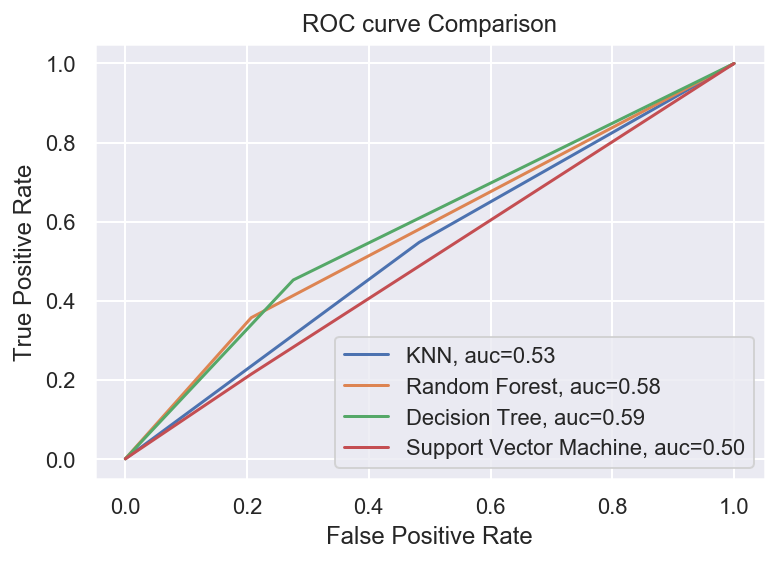

In [17]:
model_scores = fit_and_score(models=models, 
                             X_train=X_train_filled,
                             X_test=X_test_filled,
                             y_train=y_train,
                             y_test=y_test)

model_scores

## Scaled Data

In [17]:
scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test_filled)

{'KNN': 0.6,
 'Random Forest': 0.63,
 'Decision Tree': 0.54,
 'Support Vector Machine': 0.63}

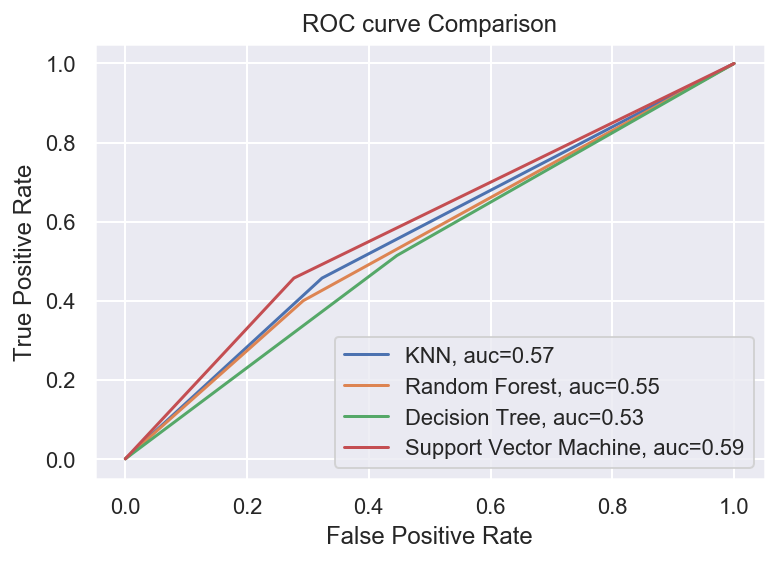

In [18]:
scaled_model_scores = fit_and_score(models=models, 
                                    X_train=X_train_scaled,
                                    X_test=X_test_scaled,
                                    y_train=y_train,
                                    y_test=y_test)

scaled_model_scores

## Principle Component Analysis

In [19]:
from sklearn.decomposition import PCA

def pca_function(x_trn, x_tst, components):
    pca = PCA(n_components=components)
    x_train = pca.fit_transform(x_trn)
    x_test = pca.transform(x_tst)
    exp_var = pca.explained_variance_ratio_
    
    plt.plot(np.cumsum(exp_var))
    plt.title('PCA data')
    plt.xlabel('Component Count')
    plt.ylabel('Cumulative Explained Variance');
    return (x_train, x_test, exp_var)

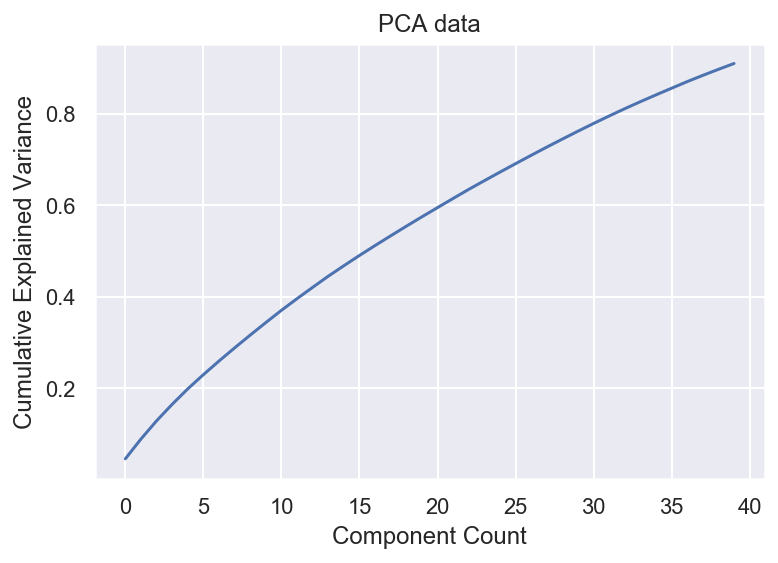

In [20]:
pca_data = pca_function(X_train_scaled, X_test_scaled, 40)

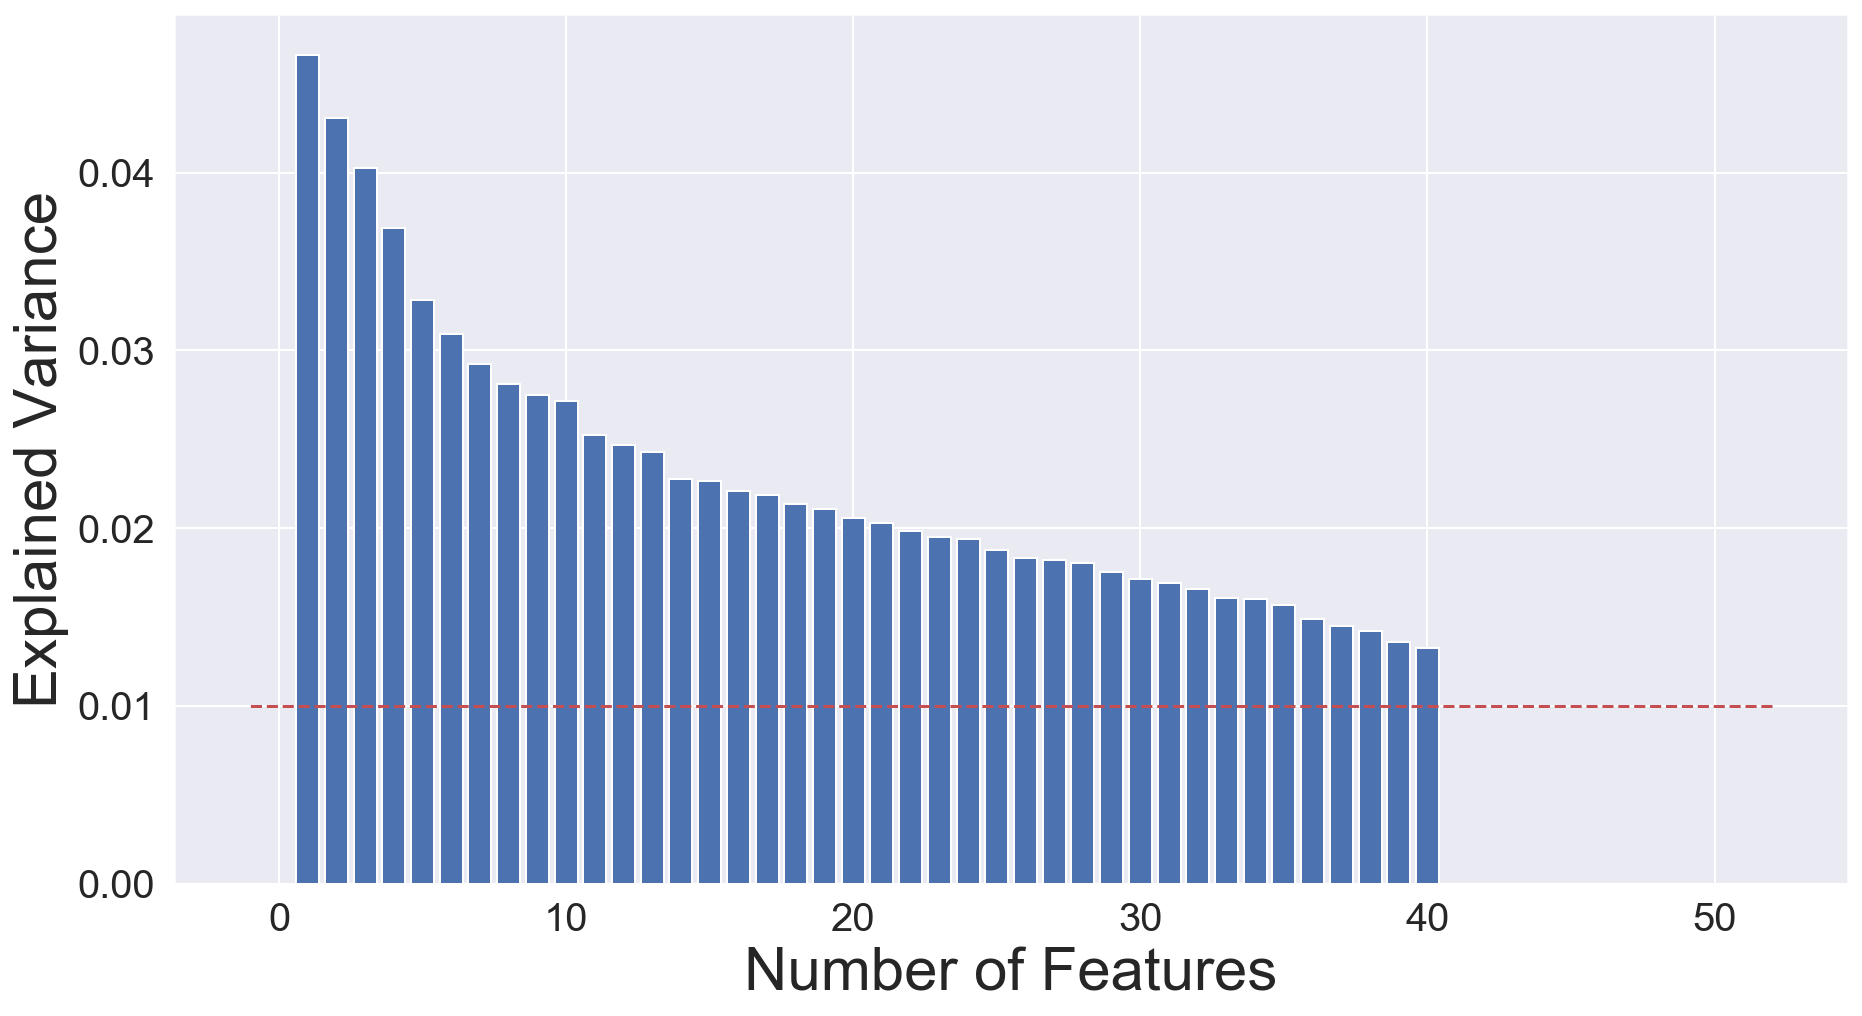

<Figure size 720x720 with 0 Axes>

In [115]:
f1, ax1 = plt.subplots(1, 1, figsize = (15, 8))


plt.bar(x=np.arange(1,41),height=pca_data[2])
plt.plot([52,-1],[0.01,0.01],'r--')
plt.figure(figsize=(10,10))
ax1.set_xlabel('Number of Features', fontsize=30)
ax1.set_ylabel('Explained Variance', fontsize=30)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.xaxis.set_tick_params(labelsize=20);

In [21]:
pca_train = pca_data[0]
pca_test = pca_data[1]

In [22]:
pca_train.shape

(400, 40)

{'KNN': 0.54,
 'Random Forest': 0.56,
 'Decision Tree': 0.55,
 'Support Vector Machine': 0.61}

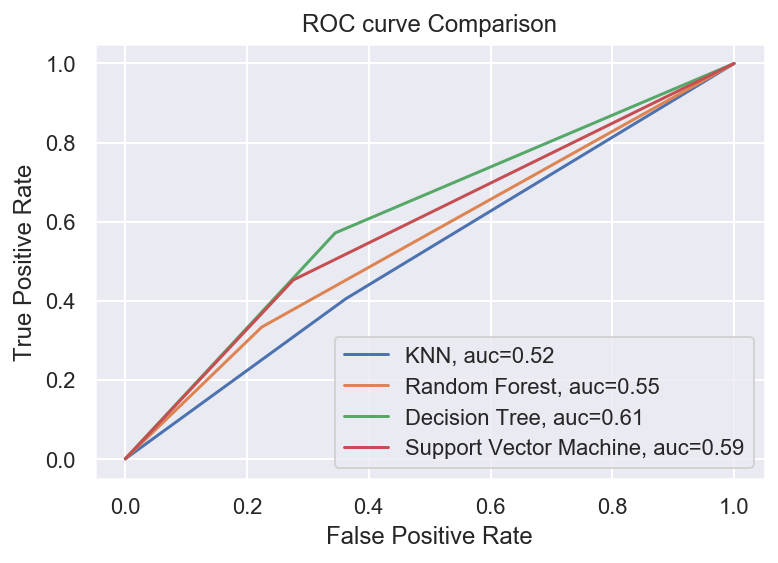

In [118]:
model_scores = fit_and_score(models=models, 
                             X_train=pca_train,
                             X_test=pca_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

## Model Evaluation

In [119]:
def evaluation(model, X_test, y_test):
    
    def return_metrics(tn, fp, fn, tp):
            acc = (tp + tn)/(tp + tn + fp + fn)
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            spef = tn/(tn + fp)
            f1 = tp/(tp + (0.5*(fp+fn)))
            return acc, prec, rec, spef, f1
    
    for model_name, each in zip(model.keys(), model.values()):
        plot_roc_curve(each, X_test, y_test, name=model_name)
        plt.plot([0, 1], [0, 1],'r--');
        
        np.random.seed(9)

        y_pred = each.predict(X_test)
        print(f'Classification Report for {model_name}')
        print(classification_report(y_test, y_pred))
        print('=========================================================')
        matrix = plot_conf_mat(y_test, y_pred)
        acc, prec, rec, spef, f1 = return_metrics(matrix[0], matrix[1], matrix[2], matrix[3])
        
        print(f'Accuracy Score: {acc:.2f}')
        print(f'Precision: {prec:.2f}')
        print(f'Recall: {rec:.2f}')
        print(f'Specificity: {spef:.2f}')
        print(f'F1 Score: {f1:.2f}')
        
        print('=========================================================')      
        

## HyperParameter Tuning

### 1) KNN Classifier

In [123]:
def plot_neighbours(X_train, X_test, y_train, y_test):
    train_scores = []
    test_scores = []

    neighbors = range(1,30)

    knn = KNeighborsClassifier()

    for each in neighbors:
        knn.set_params(n_neighbors=each)

        # fit model
        knn.fit(X_train, y_train)

        train_scores.append(knn.score(X_train, y_train))
        test_scores.append(knn.score(X_test, y_test))

    plt.figure(figsize=(15,6))
    plt.plot(neighbors, train_scores, label="Train score")
    plt.plot(neighbors, test_scores, label="Test score")
    plt.xticks(np.arange(1, 31, 1))
    plt.xlabel("Number of Neighbors", fontsize=30)
    plt.ylabel("Model score", fontsize=30)
    plt.legend()

    print(f"Best score on test data: {max(test_scores)*100:.3f}%")   

Best score on test data: 66.000%


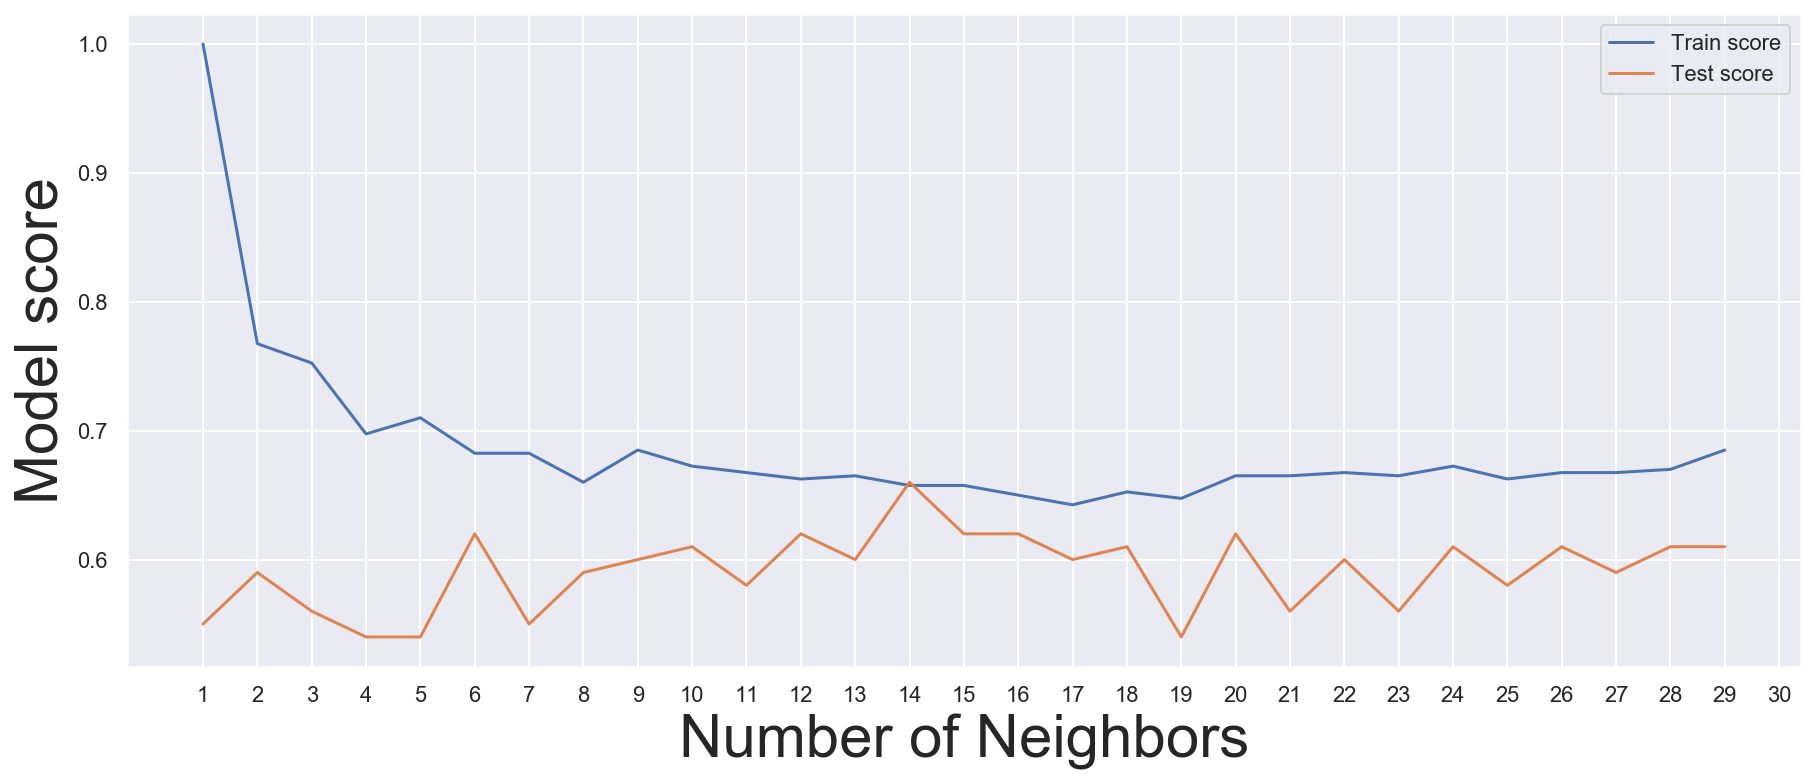

In [124]:
plot_neighbours(pca_train, pca_test, y_train, y_test)

In [129]:
best_neighbours = [9,10,14,15,17,20,21]


knn_parameters = {'n_neighbors':best_neighbours,
                  'weights':['distance','uniform'],
                  'metric':['manhattan','euclidean']}

knn_gs = GridSearchCV(KNeighborsClassifier(),
                      knn_parameters,
                      verbose=1,
                      cv=3,
                      n_jobs=-1)

In [130]:
t1 = timeit.default_timer()
knn_gs_results = knn_gs.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training time: 0.4998458670002037s


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.5s finished


Classification Report for KNN model
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        58
           1       0.53      0.40      0.46        42

    accuracy                           0.60       100
   macro avg       0.58      0.57      0.57       100
weighted avg       0.59      0.60      0.59       100

Accuracy Score: 0.51
Precision: 0.53
Recall: 0.40
Specificity: 0.62
F1 Score: 0.46


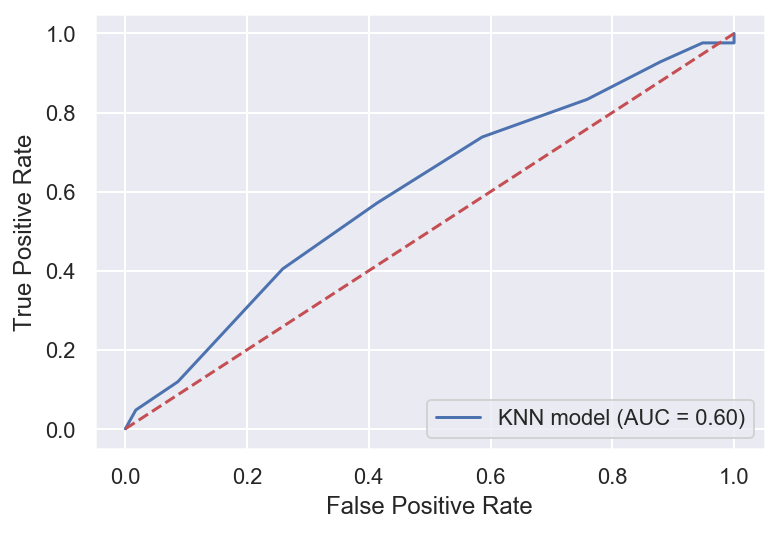

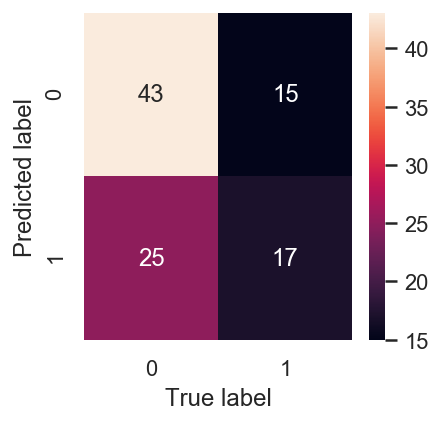

In [131]:
evaluation({"KNN model": knn_gs_results}, pca_test, y_test)

In [161]:
knn_gs.best_params_

{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

### 2) Support Vector Machines

In [132]:
svm_parameters = {'C':[0.001, 0.01, 0.1, 1, 10],
                  'gamma':[1, 0.1, 0.01, 0.001],
                  'kernel':['rbf']}

svm_gs = GridSearchCV(svm.SVC(probability=True),
                      svm_parameters,
                      cv=3,
                      verbose=1,
                      n_jobs=-1)                     

In [133]:
t1 = timeit.default_timer()
svm_gs_results = svm_gs.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training time: 1.3229315100002168s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.2s finished


Classification Report for Support Vector Machine
              precision    recall  f1-score   support

           0       0.63      0.83      0.72        58
           1       0.58      0.33      0.42        42

    accuracy                           0.62       100
   macro avg       0.61      0.58      0.57       100
weighted avg       0.61      0.62      0.59       100

Accuracy Score: 0.53
Precision: 0.58
Recall: 0.33
Specificity: 0.74
F1 Score: 0.42


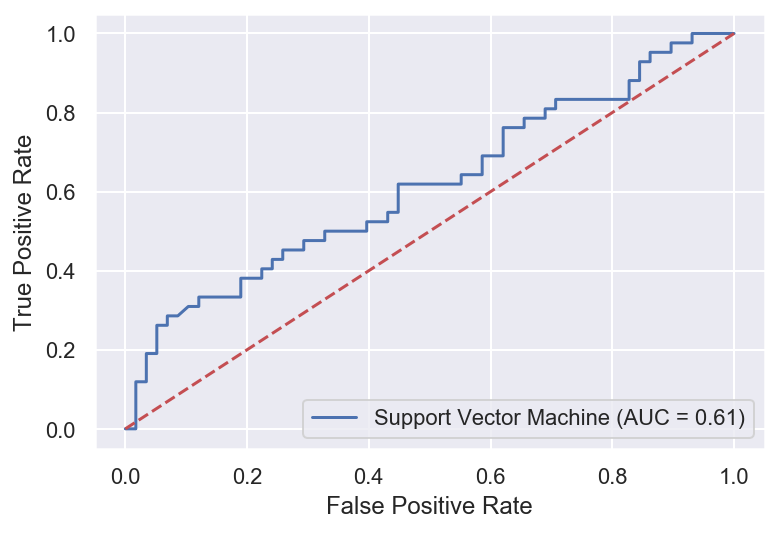

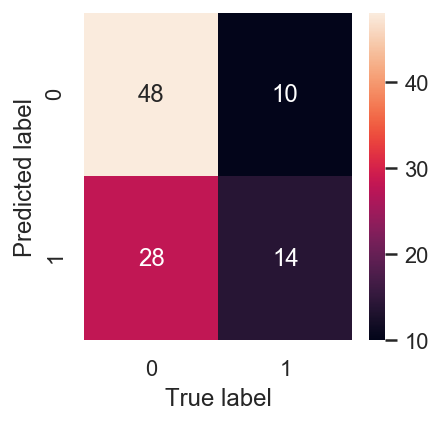

In [134]:
evaluation({"Support Vector Machine": svm_gs_results}, pca_test, y_test)

In [135]:
svm_gs.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

### 3) Decision Tree

In [139]:
dt_parameters = {'criterion':['gini','entropy'],
                 'max_depth':[2,4,6,8,10,12],
                 'splitter':['best']}

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=5),
                     dt_parameters,
                     cv=3,
                     verbose=1,
                     n_jobs=-1)     

In [141]:
t1 = timeit.default_timer()
dt_gs_results = dt_gs.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training time: 0.2670522259995778s


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.3s finished


Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        58
           1       0.47      0.45      0.46        42

    accuracy                           0.56       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.56      0.56      0.56       100

Accuracy Score: 0.49
Precision: 0.47
Recall: 0.45
Specificity: 0.52
F1 Score: 0.46


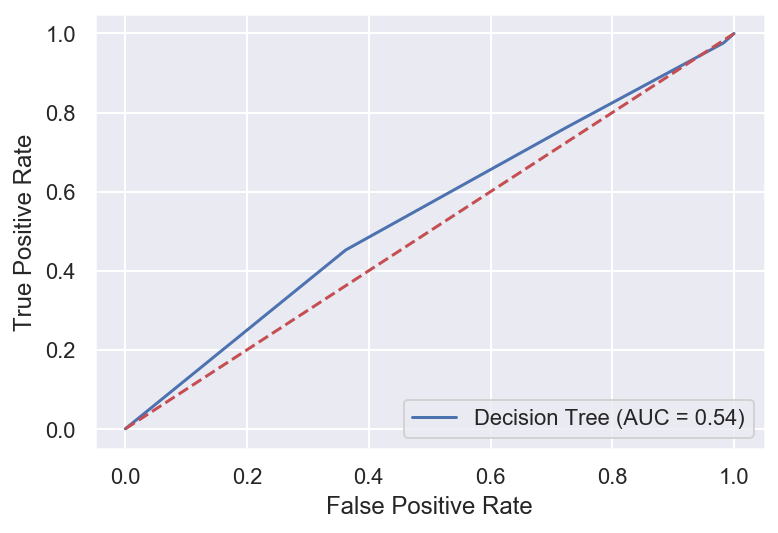

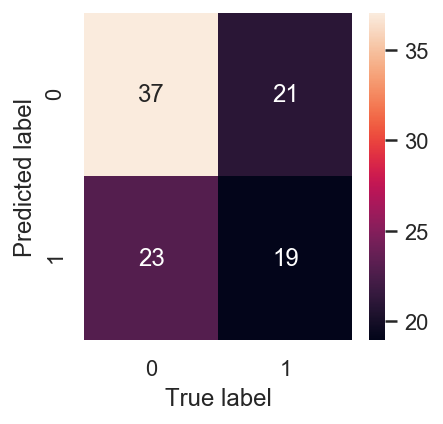

In [142]:
evaluation({"Decision Tree": dt_gs_results}, pca_test, y_test)

A Logistic Regression Classifier is also built to observe varying performance, but is not used in the final report. 

### 4) Logistic Regression Classifier

In [85]:
lr_parameters = {'penalty' : ['l1', 'l2'],
                 'C' : np.logspace(-4, 4, 20),
                 'solver' : ['liblinear', 'newton-cg']}

lr_gs = GridSearchCV(LogisticRegression(),
                     lr_parameters,
                     cv=3,
                     verbose=1,
                     n_jobs=-1)           

In [86]:
t1 = timeit.default_timer()
lr_gs_results = lr_gs.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s


Training time: 11.602117101001568s


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.6s finished


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.61      0.84      0.71        56
           1       0.61      0.32      0.42        44

    accuracy                           0.61       100
   macro avg       0.61      0.58      0.56       100
weighted avg       0.61      0.61      0.58       100

Accuracy Score: 0.53
Precision: 0.61
Recall: 0.32
Specificity: 0.77
F1 Score: 0.42


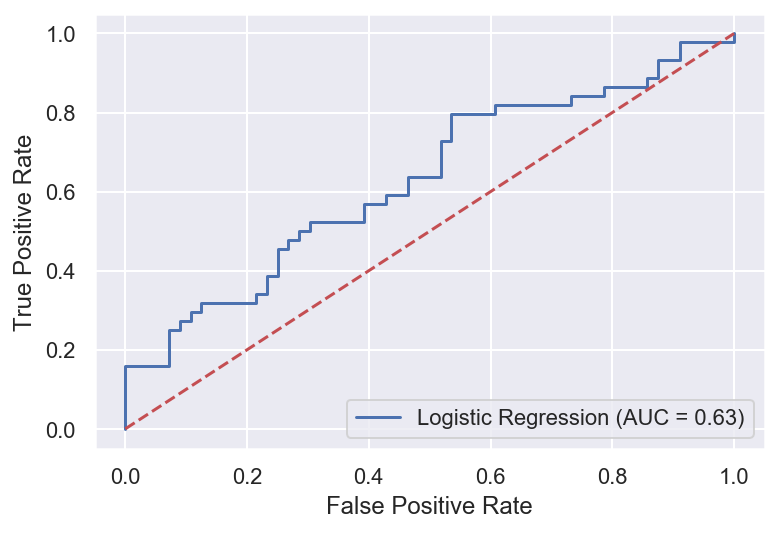

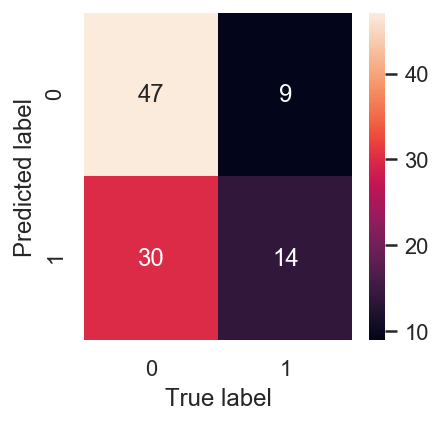

In [168]:
evaluation({"Logistic Regression": lr_gs_results}, pca_test, y_test)

In [88]:
lr_gs.best_params_

{'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'newton-cg'}

### 5) Random Forest

In [143]:
rf_parameters = {'bootstrap': [True],
                 'max_depth': [5, 10, 20, 30],
                 'max_features': ['auto'],
                 'min_samples_leaf': [1, 4, 7, ],
                 'min_samples_split': [2, 5,10],
                 'n_estimators': [100, 200, 300, 1000]}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=1),
                     rf_parameters,
                     cv=3,
                     verbose=1,
                     n_jobs=-1)           

In [144]:
t1 = timeit.default_timer()
rf_gs_results = rf_gs.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  4.1min finished


Training time: 244.0510208569999s


Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.60      0.81      0.69        58
           1       0.50      0.26      0.34        42

    accuracy                           0.58       100
   macro avg       0.55      0.54      0.52       100
weighted avg       0.56      0.58      0.55       100

Accuracy Score: 0.50
Precision: 0.50
Recall: 0.26
Specificity: 0.74
F1 Score: 0.34


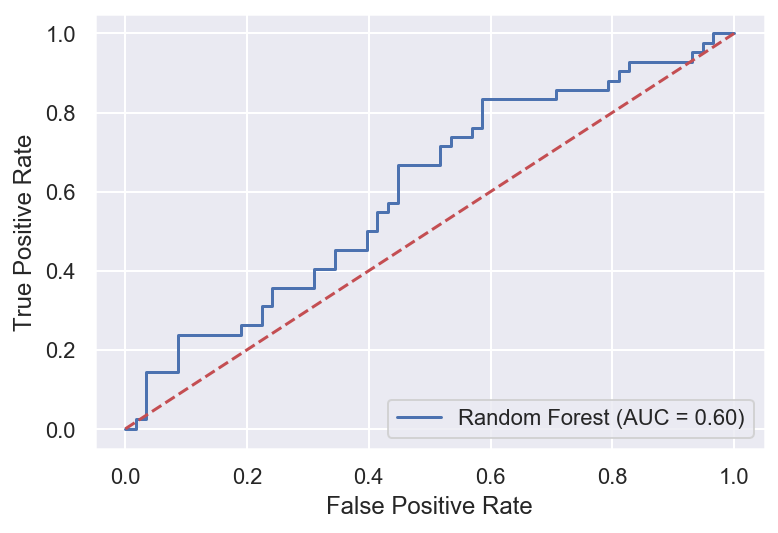

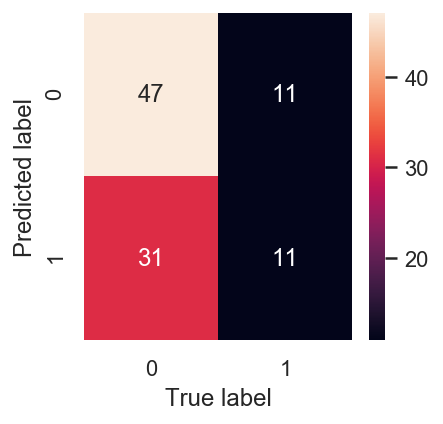

In [146]:
evaluation({"Random Forest": rf_gs_results}, pca_test, y_test)

In [147]:
rf_gs.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 300}

### 6) AdaBoost Classifier

In [159]:
# Set base model to be best performing Random Forest model
rf_model = rf_gs_results.best_estimator_
ABC_gs = AdaBoostClassifier(base_estimator = rf_model, algorithm='SAMME.R')

In [160]:
t1 = timeit.default_timer()
ABC_gs_results = ABC_gs.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Training time: 5.431806746999428s


Classification Report for AdaBoost Clasiifier (Random Forest Base)
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        58
           1       0.48      0.38      0.43        42

    accuracy                           0.57       100
   macro avg       0.55      0.54      0.54       100
weighted avg       0.56      0.57      0.56       100

Accuracy Score: 0.49
Precision: 0.48
Recall: 0.38
Specificity: 0.60
F1 Score: 0.43


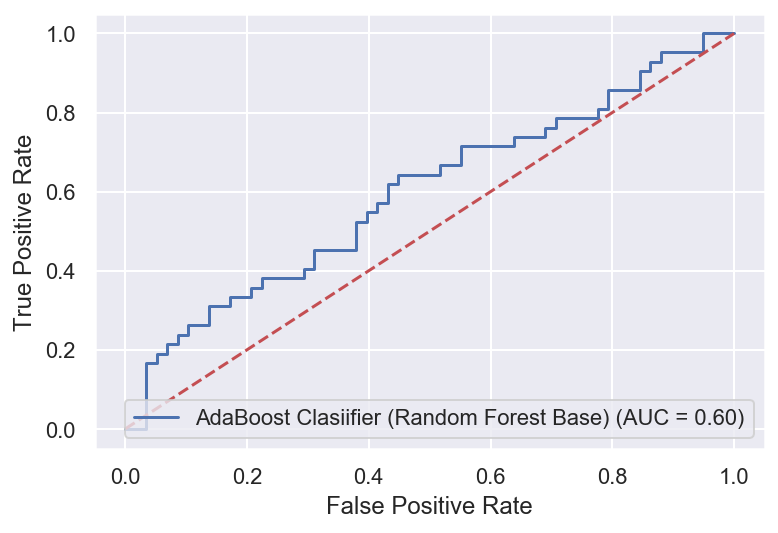

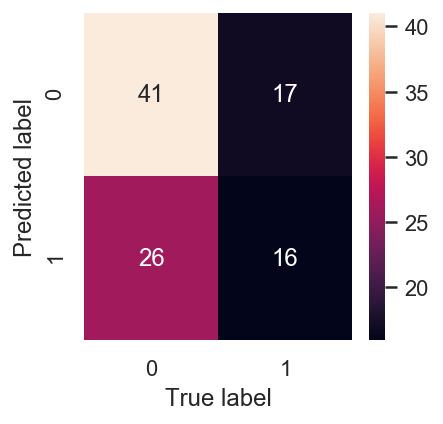

In [161]:
evaluation({"AdaBoost Clasiifier (Random Forest Base)": ABC_gs_results}, pca_test, y_test)

### 7) XGBoost

In [162]:
param = {}

num_round = 2
xg_bst = xgb.XGBClassifier(max_depth= 15, 
                           n_estimators=50,
                           learning_rate=0.3,
                           eta= 3, 
                           objective= 'binary:logistic')


t1 = timeit.default_timer()
xg_bst_results = xg_bst.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Training time: 0.4503064660002565s


Classification Report for XGBoost Classifier
              precision    recall  f1-score   support

           0       0.65      0.77      0.70        56
           1       0.62      0.48      0.54        44

    accuracy                           0.64       100
   macro avg       0.63      0.62      0.62       100
weighted avg       0.64      0.64      0.63       100

Accuracy Score: 0.55
Precision: 0.62
Recall: 0.48
Specificity: 0.64
F1 Score: 0.54


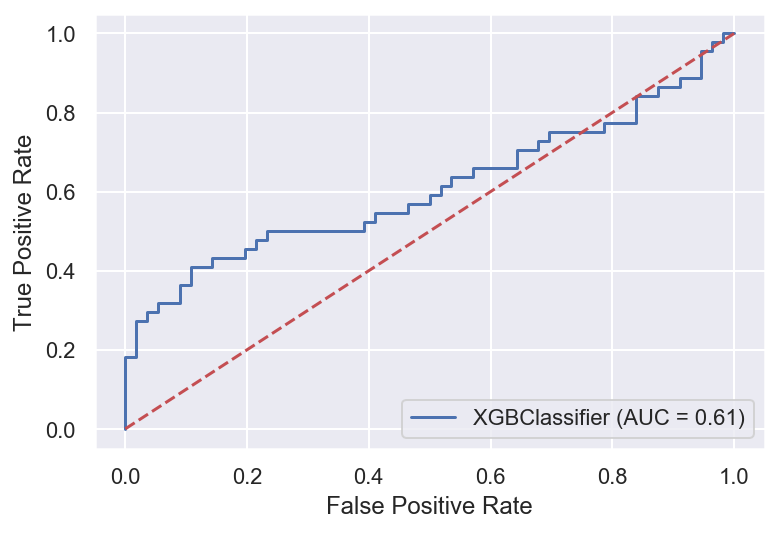

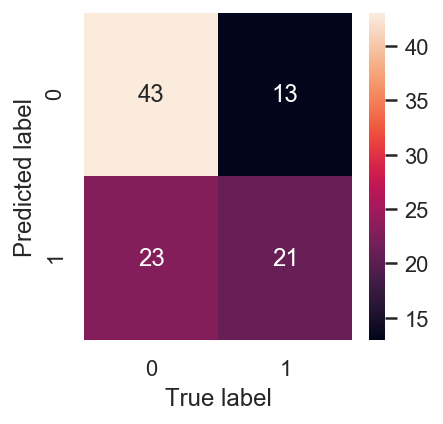

In [101]:
evaluation({"XGBoost Classifier": xg_bst_results}, pca_test, y_test)

## 8) Voting Classifier

In [163]:
voting_clf = VotingClassifier(estimators=[('XGBoost', xg_bst),
                                          ('Random Forest', rf_gs),
                                          ('AdaBoost', ABC_gs),
                                          ('Support Vector Machine', svm_gs)],
                              voting='soft')
                                          


t1 = timeit.default_timer()
voting_clf_results = voting_clf.fit(pca_train, y_train)
dt = timeit.default_timer() - t1
print(f'Training time: {dt}s')

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  5.1min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training time: 312.12605552900004s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Classification Report for Voting Classifier
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        58
           1       0.53      0.40      0.46        42

    accuracy                           0.60       100
   macro avg       0.58      0.57      0.57       100
weighted avg       0.59      0.60      0.59       100

Accuracy Score: 0.51
Precision: 0.53
Recall: 0.40
Specificity: 0.62
F1 Score: 0.46


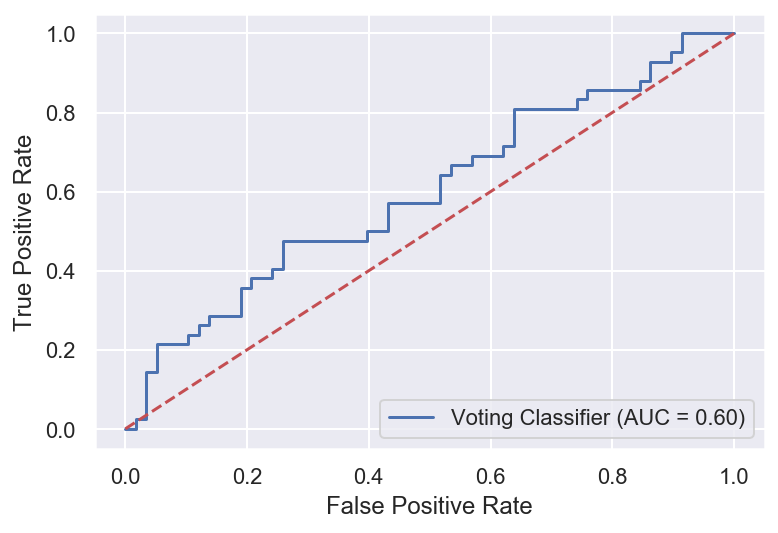

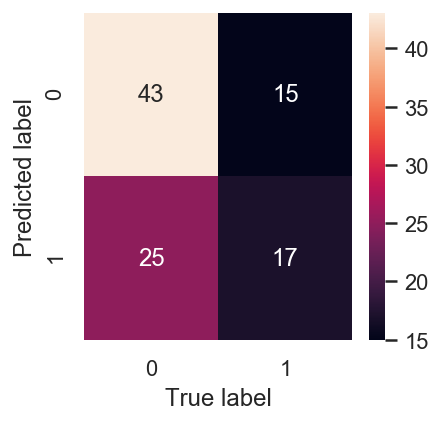

In [164]:
evaluation({"Voting Classifier": voting_clf_results}, pca_test, y_test)

## SMOTE Experiment Run

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 9)
X_train_oversampled, y_train_oversampled = sm.fit_sample(pca_train, y_train)
X_train_smote = pd.DataFrame(pca_train)
y_train_smote = y_train_oversampled

In [24]:
print(X_train_oversampled.shape)
print(y_train_oversampled.shape)
print(X_train_smote.shape)
print(y_train_smote.shape)

(450, 40)
(450,)
(400, 40)
(450,)


In [35]:
def Extract(lst): 
    return [item[-1] for item in lst] 
      
# Driver code 
lst = X_train_oversampled 
print(Extract(lst)) 

[-0.2503163697147169, -0.043355285743634446, -0.9259859705163074, 0.014898189297645435, 1.1505100251667884, 0.9451966703879496, 0.42965972654528384, 1.3340121030158525, -1.808881531944556, 0.46999230842581263, 3.84407792684587, -1.472179524234054, -0.03588869716021918, 0.41000547483605243, -0.45344626382573283, 1.7312090433447471, -0.35275051275537517, 1.029481648723736, 0.5815045903652633, 0.7248166115603406, 0.5159308765993506, -0.44360987503812854, -0.9249905054490428, -0.8355455572601299, -0.38181411968273016, -1.9350320883031114, -0.49018878734346455, 1.9427329175281367, 0.47307295778667446, -0.25513510547464313, 0.9765010379711726, 0.345730557917856, 0.8710828088886883, -1.8211401659911817, 0.3309552284802754, -0.14484432093423982, 0.15396826020929602, 0.5661615171534192, -0.7263585669363476, 0.09556094935266499, -0.30488329899212435, 0.08368967835584906, 0.26398537846881764, -0.055166265923192126, -0.15498235220173315, -0.5756976912219605, -0.26743239692583415, 0.048190425722874

### SVM Smote

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.8s finished


Training time: 4.95141206199969s
Classification Report for SMOTE Support Vector Machine
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        58
           1       0.47      0.36      0.41        42

    accuracy                           0.56       100
   macro avg       0.54      0.53      0.53       100
weighted avg       0.55      0.56      0.55       100

Accuracy Score: 0.49
Precision: 0.47
Recall: 0.36
Specificity: 0.61
F1 Score: 0.41


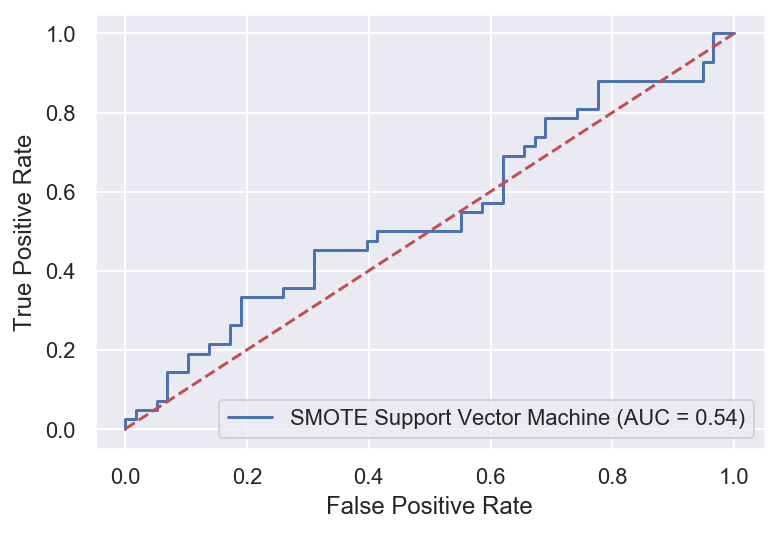

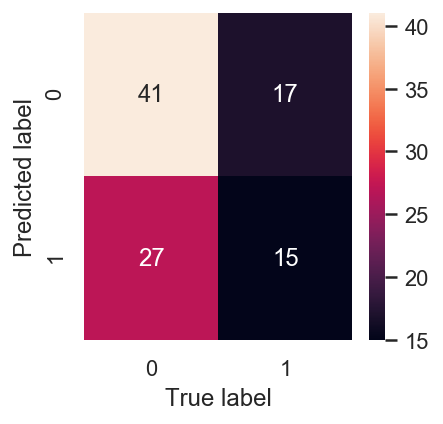

In [166]:
t2 = timeit.default_timer()
svm_smote_results = svm_gs.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE Support Vector Machine": svm_smote_results}, pca_test, y_test)

### XGBoost SMOTE

Training time: 0.3311837330002163s
Classification Report for SMOTE XGBoost
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        58
           1       0.48      0.48      0.48        42

    accuracy                           0.56       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.56      0.56      0.56       100

Accuracy Score: 0.49
Precision: 0.48
Recall: 0.48
Specificity: 0.50
F1 Score: 0.48


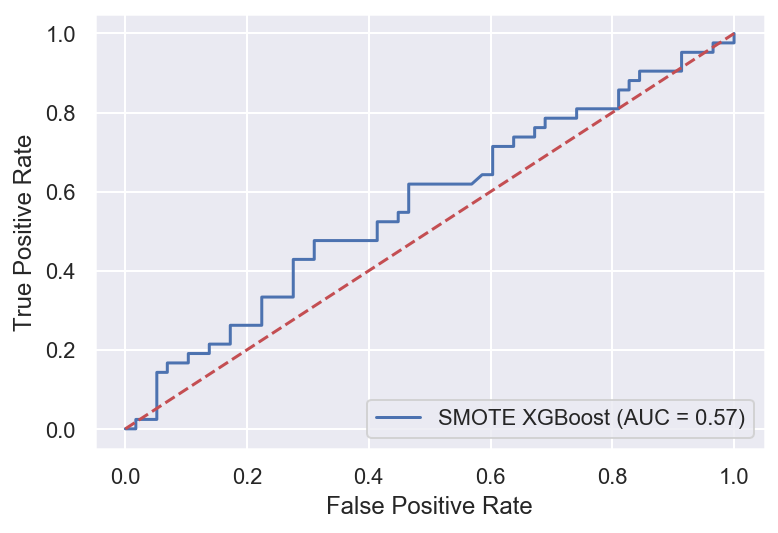

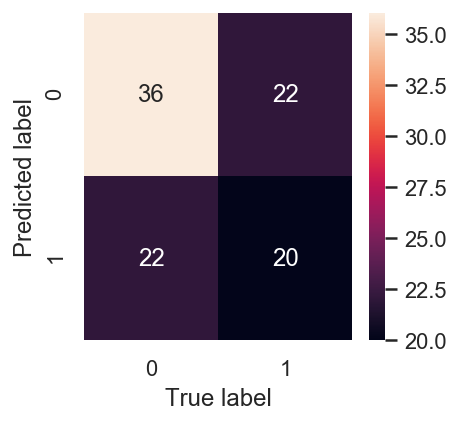

In [167]:
t2 = timeit.default_timer()
xgb_smote_results = xg_bst.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE XGBoost": xgb_smote_results}, pca_test, y_test)

### KNN SMOTE

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.9s finished


Training time: 0.9377977559997817s
Classification Report for SMOTE K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.61      0.43      0.51        58
           1       0.44      0.62      0.51        42

    accuracy                           0.51       100
   macro avg       0.53      0.53      0.51       100
weighted avg       0.54      0.51      0.51       100

Accuracy Score: 0.46
Precision: 0.44
Recall: 0.62
Specificity: 0.33
F1 Score: 0.51


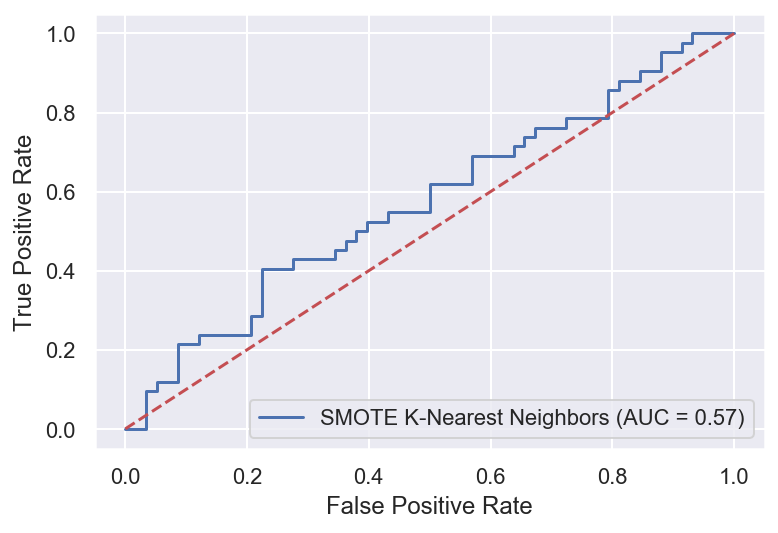

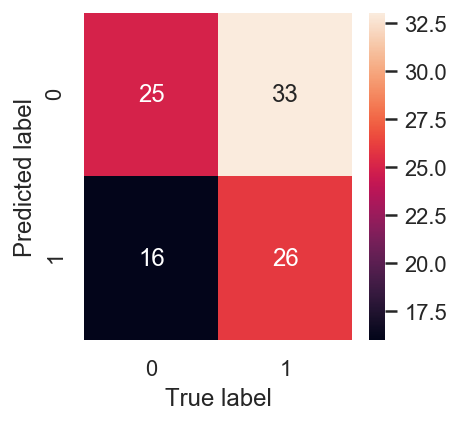

In [168]:
t2 = timeit.default_timer()
knn_smote_results = knn_gs.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE K-Nearest Neighbors": knn_smote_results}, pca_test, y_test)

### Voting SMOTE

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  4.0min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.1s finished


Training time: 247.73875657600001s
Classification Report for SMOTE Voting Classifier
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        58
           1       0.49      0.50      0.49        42

    accuracy                           0.57       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.57      0.57      0.57       100

Accuracy Score: 0.49
Precision: 0.49
Recall: 0.50
Specificity: 0.49
F1 Score: 0.49


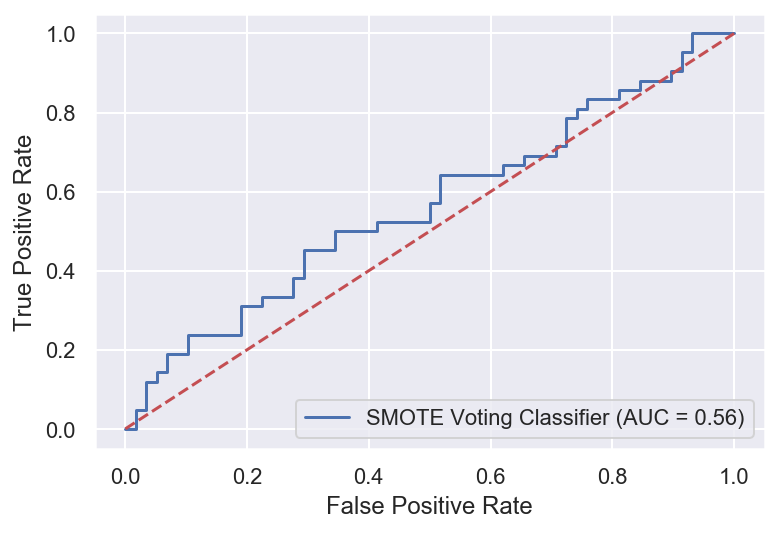

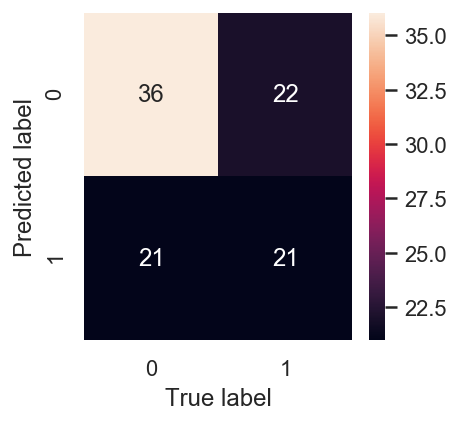

In [169]:
t2 = timeit.default_timer()
vote_smote_results = voting_clf.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE Voting Classifier": vote_smote_results}, pca_test, y_test)

### AdaBoost SMOTE

Training time: 4.0870710399995005s
Classification Report for SMOTE AdaBoost
              precision    recall  f1-score   support

           0       0.65      0.64      0.64        58
           1       0.51      0.52      0.52        42

    accuracy                           0.59       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.59      0.59      0.59       100

Accuracy Score: 0.51
Precision: 0.51
Recall: 0.52
Specificity: 0.49
F1 Score: 0.52


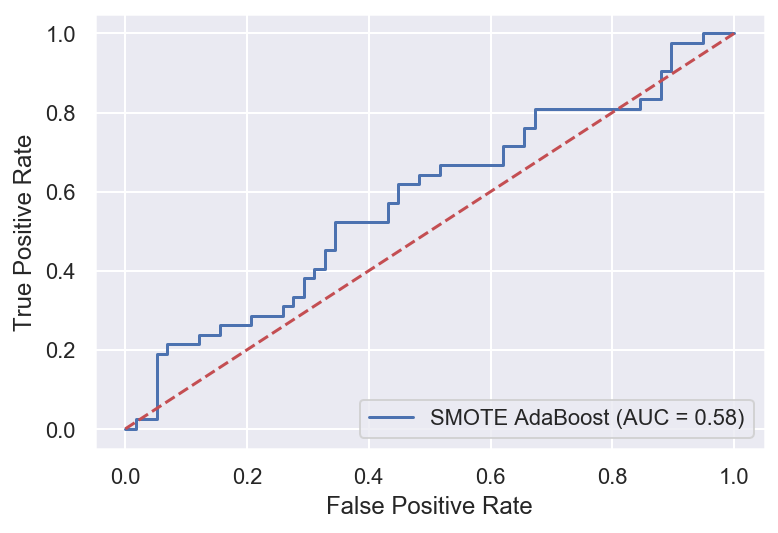

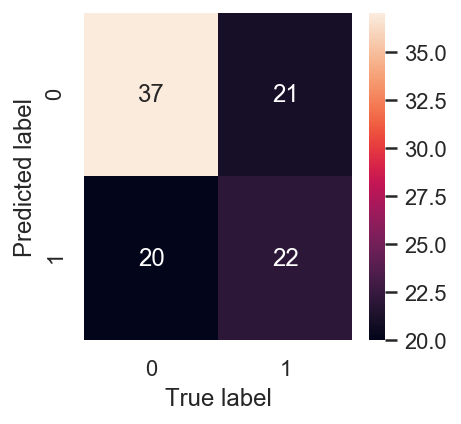

In [170]:
t2 = timeit.default_timer()
ABC_smote_results = ABC_gs.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE AdaBoost": ABC_smote_results}, pca_test, y_test)

### Decision Tree SMOTE

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.1s finished


Training time: 3.109203940000043s
Classification Report for SMOTE Decision Tree
              precision    recall  f1-score   support

           0       0.57      0.45      0.50        58
           1       0.41      0.52      0.46        42

    accuracy                           0.48       100
   macro avg       0.49      0.49      0.48       100
weighted avg       0.50      0.48      0.48       100

Accuracy Score: 0.45
Precision: 0.41
Recall: 0.52
Specificity: 0.38
F1 Score: 0.46


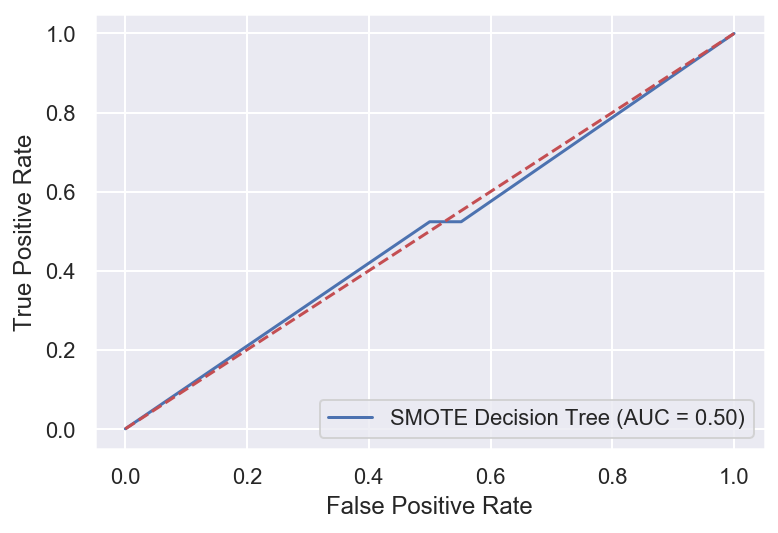

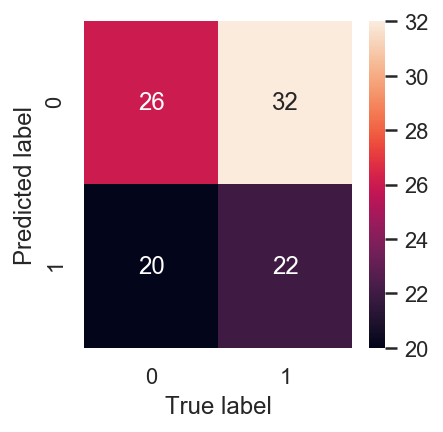

In [171]:
t2 = timeit.default_timer()
DT_smote_results = dt_gs.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE Decision Tree": DT_smote_results}, pca_test, y_test)

### Random Forest SMOTE

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  4.0min finished


Training time: 241.46366744700026s
Classification Report for SMOTE Random Forest
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        58
           1       0.50      0.50      0.50        42

    accuracy                           0.58       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.58      0.58      0.58       100

Accuracy Score: 0.50
Precision: 0.50
Recall: 0.50
Specificity: 0.50
F1 Score: 0.50


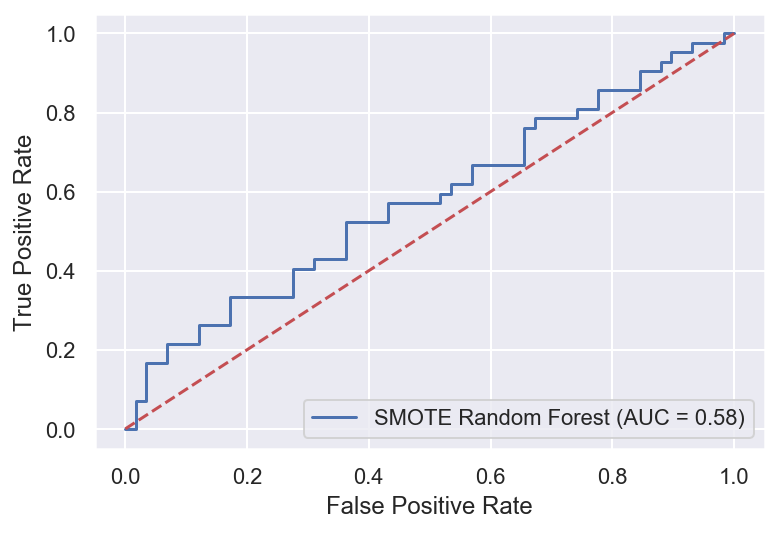

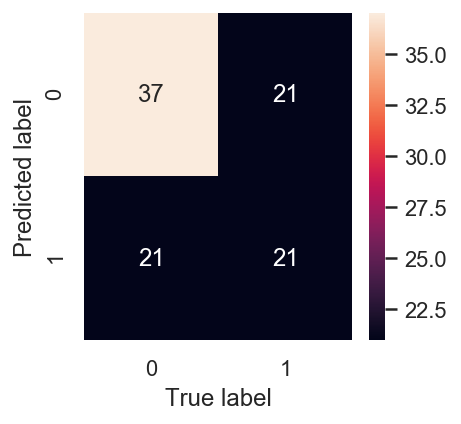

In [172]:
t2 = timeit.default_timer()
rf_smote_results = rf_gs.fit(X_train_oversampled, y_train_oversampled)
dt2 = timeit.default_timer() - t2
print(f'Training time: {dt2}s')

evaluation({"SMOTE Random Forest": rf_smote_results}, pca_test, y_test)

In [ ]:
X